In [1]:
import urllib.request
import zipfile
import os
from pathlib import Path
import pandas as pd
import tiktoken
import torch
import time
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from gpt_download import download_and_load_gpt2
import matplotlib.pyplot as plt
from Pretraining import GPTModel
from GPT2 import load_weights_into_gpt
from GPT_architecture import Generate_text
from Pretraining import text_to_token_ids, token_ids_to_txt

In [2]:
df = pd.read_csv("SMSSpamCollection.tsv", sep="\t", header=None)
df.columns = ["label", "message"]

In [3]:
df['label'].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

In [4]:
# Balance the classes
def create_balanced_dataset(df):
    num_spam= df[df['Label'] == "spam"].shape[0]
    ham_subset= df[df['Label'] == "ham"].sample(num_spam, random_state=123)
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df

In [5]:
def random_split(df, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

In [6]:
# Pad all the dataset to have the same length -> we padded all the sentences to be as long as the longest sentence of the dataset
class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        self.encoded_texts = [
                tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length

            self.encoded_texts = [
                    encoded_text[:self.max_length]
                    for encoded_text in self.encoded_texts
            ]

        self.encoded_texts = [
                encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
                for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
                torch.tensor(encoded, dtype=torch.long),
                torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [7]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i >= num_batches:
            break
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)

        with torch.no_grad():
            logits = model(input_batch)[:, -1, :]
        predicted_labels = torch.argmax(logits, dim=-1)

        num_examples += predicted_labels.shape[0]
        correct_predictions += (predicted_labels == target_batch).sum().item()
    return correct_predictions / num_examples

In [8]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :] # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [9]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i >= num_batches:
            break
        loss = calc_loss_batch(input_batch, target_batch, model, device)
        total_loss += loss.item()
    return total_loss / num_batches

In [10]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss= calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss= calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [12]:
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0) # Invinsible
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

In [16]:
def train_classifier(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter, tokenizer):
    train_losses, val_losses, train_accuracies, val_accuracies= [],[],[],[]
    examples_seen, global_steps= 0,-1
    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss= calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            examples_seen+=input_batch.shape[0]
            global_steps+=1

            if global_steps%eval_freq==0:
                train_loss, val_loss= evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep{epoch+1} (Step {global_steps:06d})"
                      f"train loss {train_loss:.3f}, val loss {val_loss:.3f}")
        train_accuracy= calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy= calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy:{train_accuracy*100:.2f}% |", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy) 
    return train_losses, val_losses, train_accuracies, val_accuracies, examples_seen


In [21]:
def classify_review(text, model, tokenizer, device, max_len=None, pad_token_ids=50256):
    model.eval()

    input_ids= tokenizer.encode(text)
    supported_context_len= model.pos_emb.weight.shape[1]
    input_ids= input_ids[:min(max_len, supported_context_len)]

    input_ids+=[pad_token_ids]*(max_len-len(input_ids))
    input_tensor= torch.tensor(input_ids, device=device).unsqueeze(0)

    with torch.no_grad():
        logits= model(input_tensor)[:,-1,:]
    predicted_labels= torch.argmax(logits, dim=-1).item()

    # Print the text being checked
    print(f"Text being checked: {text}")
    
    result = "You are getting scammed girlie pop" if predicted_labels==1 else "not a spam girlie pop"
    print(f"My Review : {result}")
    
    return result

In [22]:
def main():
    # Downloading file
    data_file_path= "SMSSpamCollection.tsv"

    # Loading it into panda dataframes
    df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
    print(df["Label"].value_counts())

    # Get balanced dataset for finetuning
    balanced_df = create_balanced_dataset(df)
    print("Balanced dataset value counts:\n", balanced_df["Label"].value_counts())

    # Convert string class labels to 0 and 1
    balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

    # 70% for training, 10% for validation adn 20% for testing 
    train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

    # Save to csv to re-use later
    train_df.to_csv("train.csv", index=None)
    validation_df.to_csv("validation.csv", index=None)
    test_df.to_csv("test.csv", index=None)

    # Verifying which is <|endoftext|> token for padding
    tokenizer = tiktoken.get_encoding("gpt2")
    print("<|endoftext|> token id is ", tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

    # Creating data sets
    train_dataset = SpamDataset(
            csv_file="train.csv",
            max_length=None,
            tokenizer = tokenizer
    )
    print("Longest sequence in the dataset is ", train_dataset.max_length)
    val_dataset = SpamDataset(
            csv_file="validation.csv",
            max_length=train_dataset.max_length,
            tokenizer=tokenizer
    )
    test_dataset = SpamDataset(
            csv_file="test.csv",
            max_length=train_dataset.max_length,
            tokenizer=tokenizer
    )

    # Creating dataloaders
    num_workers = 0
    batch_size = 8
    torch.manual_seed(123)

    train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            drop_last=True,
    )
    val_loader = DataLoader(
            dataset=val_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            drop_last=False,
    )
    test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            drop_last=False,
    )

    # Ensure data loaders are working correctly, iterate over the training loader and print tensor dimensions of the last batch
    for input_batch, target_batch in train_loader:
        pass
    print("Input batch dimensions:", input_batch.shape)
    print("Label batch dimensions:", target_batch.shape)

    print(f"{len(train_loader)} training batches")
    print(f"{len(val_loader)} validation batches")
    print(f"{len(test_loader)} test batches")

    # 6.4 Initialize a model with pretrained weights
    CHOOSE_MODEL = "gpt2-small (124M)"
    INPUT_PROMPT = "Every effort moves"
    BASE_CONFIG = {
            "vocab_size": 50257,     # Vocabulary size
            "context_length": 1024,  # Context length
            "drop_rate": 0.0,        # Dropout rate
            "qkv_bias": True         # Query-key-value bias
    }
    model_configs = {
            "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
            "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
            "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
            "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
    }
    BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

    assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
            f"Dataset length {train_dataset.max_length} exceeds model's context "
            f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
            f"`max_length={BASE_CONFIG['context_length']}`"
    )

    model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
    settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")
    
    model = GPTModel(BASE_CONFIG)
    load_weights_into_gpt(model, params)
    model.eval()
    
    # Model is loaded, lets ensure it generate coherent text
    text_1 = "Every effort moves you"
    token_ids = Generate_text(
            model=model,
            idx=text_to_token_ids(text_1, tokenizer),
            max_new_tokens=15,
            context_size=BASE_CONFIG["context_length"]
    )
    print(token_ids_to_txt(token_ids, tokenizer))

    # Lets see if the model can classify spam messages by prompting it with instructions
    text_2 = (
            "Is the following text 'spam'? Answer with 'yes' or 'no':"
            " 'You are a winner you have been specially"
            " selected to receive $1000 cash or a $2000 award.'"
    )
    token_ids = Generate_text(
            model=model,
            idx=text_to_token_ids(text_2, tokenizer),
            max_new_tokens=23,
            context_size=BASE_CONFIG["context_length"]
    )
    print(token_ids_to_txt(token_ids, tokenizer))

    # 6.5 Onto modifying the pre-trained model
    # Let's first print the current state
    print(model)

    # Freeze the model, make the layers non-trainable
    for param in model.parameters():
        param.requires_grad = False

    # Replace output head
    torch.manual_seed(123)
    num_classes = 2
    model.out_head = torch.nn.Linear(
            in_features=BASE_CONFIG["emb_dim"],
            out_features=num_classes
    )
    # Make the last LayerNorm and Transformer block trainable
    for param in model.trf_blocks[-1].parameters():
        param.requires_grad = True
    for param in model.final_norm.parameters():
        param.requires_grad = True

    inputs = tokenizer.encode("Do you have time")
    inputs = torch.tensor(inputs).unsqueeze(0)
    print("Inputs:", inputs)
    print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)
    with torch.no_grad():
        outputs = model(inputs)
    print("Outputs:\n", outputs)
    print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)
    print("Last output token:", outputs[:, -1, :])

    # Obtaining the class label for that example
    logits = outputs[:, -1, :]
    label = torch.argmax(logits)
    print("Class label:", label.item())

    # Test out classification accuracies
    device = torch.device("cpu") # torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)

    torch.manual_seed(123)
    train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
    val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
    test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

    print(f"Training accuracy: {train_accuracy*100:.2f}%")
    print(f"Validation accuracy: {val_accuracy*100:.2f}%")
    print(f"Test accuracy: {test_accuracy*100:.2f}%")

    # Computing initial loss for each data set
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
        test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)
    print("The initial loss values are as follows:\n")
    print(f"Training loss: {train_loss:.3f}")
    print(f"Validation loss: {val_loss:.3f}")
    print(f"Test loss: {test_loss:.3f}")

    # Time to train! 
    start_time = time.time()
    torch.manual_seed(123)
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
    num_epochs = 5

    train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier(
            model, train_loader, val_loader, optimizer, device,
            num_epochs=num_epochs, eval_freq=50, eval_iter=5,
            tokenizer=tokenizer
    )
    end_time = time.time()
    execution_time_minutes = (end_time - start_time) / 60
    print(f"Training completed in {execution_time_minutes:.2f} minutes.")

    # Plotting what we got
    epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
    examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

    plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

    epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
    examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
    plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

    # Now evaluate accuracy for the entire dataset
    train_accuracy = calc_accuracy_loader(train_loader, model, device)
    val_accuracy = calc_accuracy_loader(val_loader, model, device)
    test_accuracy = calc_accuracy_loader(test_loader, model, device)

    print(f"Training accuracy: {train_accuracy*100:.2f}%")
    print(f"Validation accuracy: {val_accuracy*100:.2f}%")
    print(f"Test accuracy: {test_accuracy*100:.2f}%")

    text_1 = (
            "You are a winner you have been specially"
            " selected to receive $1000 cash or a $2000 award."
    )
    print(classify_review(
        text_1, model, tokenizer, device, max_len=train_dataset.max_length
    ))

    text_2 = (
            "Hey, just wanted to check if we're still on"
            " for dinner tonight? Let me know!"
    )
    print(classify_review(
        text_2, model, tokenizer, device, max_len=train_dataset.max_length
    ))

    # Saving model for later re-use without having to train
    torch.save(model.state_dict(), "review_classifier.pth")

    # Once saved the model can be loaded as follows
    model_state_dict = torch.load("review_classifier.pth")
    model.load_state_dict(model_state_dict)

Label
ham     4825
spam     747
Name: count, dtype: int64
Balanced dataset value counts:
 Label
ham     747
spam    747
Name: count, dtype: int64
<|endoftext|> token id is  [50256]
Longest sequence in the dataset is  120
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions: torch.Size([8])
130 training batches
19 validation batches
38 test batches
File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe
Every effort moves you

" " " " " " " " " " " " "
Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash o

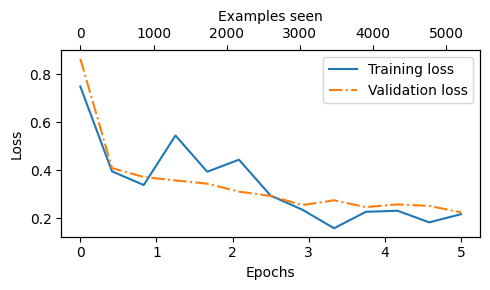

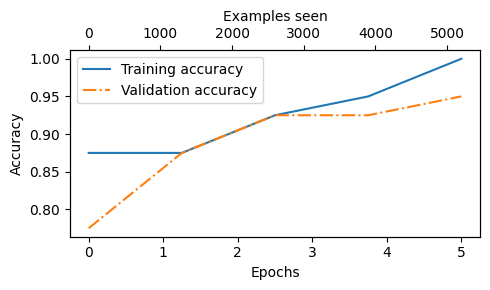

Training accuracy: 94.13%
Validation accuracy: 95.97%
Test accuracy: 92.00%
Text being checked: You are a winner you have been specially selected to receive $1000 cash or a $2000 award.
My Review : You are getting scammed girlie pop
You are getting scammed girlie pop
Text being checked: Hey, just wanted to check if we're still on for dinner tonight? Let me know!
My Review : not a spam girlie pop
not a spam girlie pop


In [23]:
if __name__ == "__main__":
    main()